In [1]:
import numpy as np
import pandas as pd
import time as tm
import math # to calculate distance between servers

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA # use pca reduce dims
from mpl_toolkits.mplot3d import Axes3D # plot 3d figure
from s_dbw import S_Dbw # evaluate clustering

from matplotlib import pyplot

from sklearn.cluster import MeanShift # a clustering algorithm decide the n_cluster automatically

import seaborn as sns # plot heatmap

In [2]:
# 6.1 CJS Model in US-0 V.S. US-1

In [3]:
# Data Processing - read data from .csv file

data_loc = 'us'
file = f'../Data/{data_loc}.csv'

df = pd.read_csv(file)
df = pd.DataFrame(df)

time_start = tm.time()

ip_time = dict()
special_chr = ["{", "}", "'", ":", " "]

for i in range(len(df)):
    raw_points = df['transactionList'][i]
    points = ''.join(e for e in raw_points if e not in special_chr)
    points = points.split(",")
    for j in range(len(points)):
        time = points[j][:17]
        ip = points[j][17:]
        if ip not in ip_time:
            ip_time[ip] = [time]
        else:
            ip_time[ip].append(time)

time_end = tm.time()
runtime = time_end - time_start
print(f'runtime: {runtime} second')

total_num = len(ip_time)
print(f'num of total server: {total_num}')

print(f'Data Size of "{data_loc}": {len(df)}')

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\3301646557.py:6: DtypeWarning: Columns (1,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


runtime: 44.65845704078674 second
num of total server: 619
Data Size of "us": 284249


In [4]:
# select specific period from the dataset, "ip_time"

def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(ip_data=ip_data, period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(ip_data=ip_data, period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

# get 2021 data - US-All
data_us_all = get_ip_time()

# get US-1 data - 2021-05-07~2021-05-16 (for us dataset)
us_1 = ['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11',
            '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16']
data_us_1 = get_ip_time(period=us_1)

# get US-0 data - 2021-04-29~2021-05-05 (for us dataset)
us_0 = ['2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03',
        '2021-05-04', '2021-05-05']
data_us_0 = get_ip_time(period=us_0)

dates = [us_0, us_1]

# check the data
for ip in data_us_1:
    print(f'ip: {ip}')
    print(data_us_1[ip][:5])
    break

ip: 52.223.228.27
['2021-05-07T000111', '2021-05-07T002416', '2021-05-07T003212', '2021-05-07T002644', '2021-05-07T003952']


In [5]:
# setup hour axis for below chart
hour_axis = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [6]:
# number of ip in sample hour and baseline every dates
def baseline_sample_ip_num_dates(data, sample_hour):
    day_sample_ip_num = dict()
    day_baseline_ip_num = dict()
    for ip in data:
        for time in data[ip]:
            date = time[5:10]
            hour = time[11:13]
            if date not in day_baseline_ip_num: # in baseline
                day_baseline_ip_num[date] = [ip]
            elif ip not in day_baseline_ip_num[date]:
                day_baseline_ip_num[date].append(ip)
            if hour == sample_hour: # in sample hour
                if date not in day_sample_ip_num:
                    day_sample_ip_num[date] = [ip]
                elif ip not in day_sample_ip_num[date]:
                    day_sample_ip_num[date].append(ip)
                elif ip in day_sample_ip_num[date]:
                    if ip not in day_baseline_ip_num[date]:
                        print(f'date: {date}, ip: {ip}')
    # caculate number of ip
    x_dates = list()
    sample_num_axis = list()
    baseline_num_axis = list()
    for date in sorted(day_baseline_ip_num):
        x_dates.append(date)
        sample_num_axis.append(len(day_sample_ip_num[date]))
        baseline_num_axis.append(len(day_baseline_ip_num[date]))
    sample_ratio = np.array(sample_num_axis) / np.array(baseline_num_axis)
    return x_dates, sample_num_axis, baseline_num_axis, sample_ratio

In [7]:
def plot_2_ax(title, region, period, x_axis, y1_axis, y2_axis, x_label, y1_label, y2_label, x_rotation=False):
    fig, ax1 = plt.subplots()
    pyplot.title(f'{title} - {region} {period}')
    if x_rotation:
        pyplot.xticks(rotation=45)
    pyplot.xlabel(x_label)
    ax2 = ax1.twinx()

    ax1.set_ylabel(y1_label, color='tab:blue')
    ax1.plot(x_axis, y1_axis, color='tab:blue')
    ax1.tick_params(axis='y')

    ax2.set_ylabel(y2_label, color='orange')
    ax2.plot(x_axis, y2_axis, color='orange')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    pyplot.show()
    
def plot_2_line(title, region, period, x_axis, y1_axis, y2_axis, x_label, y1_label, y2_label, x_rotation=False):
    pyplot.title(f'{title} - {region} {period}')
    if x_rotation:
        pyplot.xticks(rotation=45)
    pyplot.xlabel(x_label)
    pyplot.plot(x_axis, y1_axis, label=y1_label)
    pyplot.plot(x_axis, y2_axis, label=y2_label)
    pyplot.legend()
    pyplot.show()

data_loc: us
sample_hour: 00


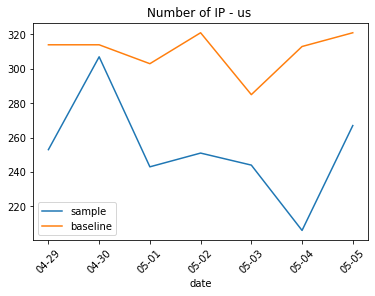


US-0
total number of servers: 322
std/avg(sample_num): 0.11085328370452485
std/avg(baseline_num): 0.03769751720978374


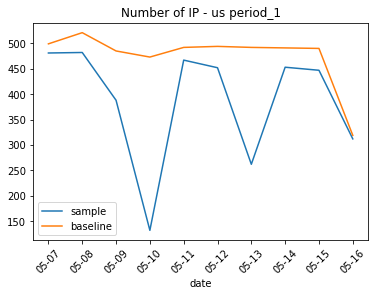


US-1
total number of servers: 538
std/avg(sample_num): 0.2858011656621988
std/avg(baseline_num): 0.11234378213640349

Table 6.1: Overview of US-0 and US-1


In [8]:
# Table 6.1: Overview of US-0 and US-1

# error rates (no clustering) are in the folders,
# '../Result/us_period_0/p2_est_result' and '../Result/us_period_1/p2_est_result'

print(f'data_loc: {data_loc}')

if data_loc == 'United_Kingdom':
    sample_hour = '20'
elif data_loc == 'Netherlands' or data_loc == 'France' or data_loc == 'Germany':
    sample_hour = '19'
elif data_loc == 'us_period_0' or data_loc == 'us_period_0' or data_loc == 'us':
    sample_hour = '00'
    
print(f'sample_hour: {sample_hour}')

date_axis, sample_num, baseline_num, sample_ratio = baseline_sample_ip_num_dates(data_us_0, sample_hour)
plot_2_line(title='Number of IP',
          region=data_loc, period='',
          x_axis=date_axis, y1_axis=sample_num, y2_axis=baseline_num, 
          x_label='date', y1_label='sample', y2_label='baseline', x_rotation=True)
print('\nUS-0')
print(f'total number of servers: {len(data_us_0)}')
print(f'std/avg(sample_num): {np.std(np.array(sample_num))/np.mean(np.array(sample_num))}')
print(f'std/avg(baseline_num): {np.std(np.array(baseline_num))/np.mean(np.array(baseline_num))}')

date_axis, sample_num, baseline_num, sample_ratio = baseline_sample_ip_num_dates(data_us_1, sample_hour)
plot_2_line(title='Number of IP',
          region=data_loc, period='period_1',
          x_axis=date_axis, y1_axis=sample_num, y2_axis=baseline_num, 
          x_label='date', y1_label='sample', y2_label='baseline', x_rotation=True)
print('\nUS-1')
print(f'total number of servers: {len(data_us_1)}')
print(f'std/avg(sample_num): {np.std(np.array(sample_num))/np.mean(np.array(sample_num))}')
print(f'std/avg(baseline_num): {np.std(np.array(baseline_num))/np.mean(np.array(baseline_num))}')

print('\nTable 6.1: Overview of US-0 and US-1')

In [9]:
# Table 6.2: Correlation with Error Rate - the US

# the value is shown in chapter 5

# data = k-means
# Table 5.3: Correlation Matrix - US-1
# Table 5.7: Correlation Matrix - US-0

# data = random clustering
# Table 5.9: Correlation Matrix - Random Clustering in US-0
# Table 5.10: Correlation Matrix - Random Clustering in US-1

print('Table 6.2: Correlation with Error Rate - the US')

Table 6.2: Correlation with Error Rate - the US


In [10]:
# Table 6.3: Correlation with Cluster Error Rate - the US

# the value is shown in the file, ch5_CJS_Estimation_Error.ipynb

# data = k-means
# The correlation matrix in the block, 'Figure 5.5'
# The correlation matrix in the block, 'Figure 5.11'

# data = random clustering
# The correlation matrix in the block 'Figure 5.16'
# The correlation matrix in the block 'Figure 5.19'

print('Table 6.3: Correlation with Cluster Error Rate - the US')

Table 6.3: Correlation with Cluster Error Rate - the US


In [11]:
# 6.2 CJS Model in the United Kingdom

In [12]:
def read_dataset_csv(data_loc):
    file = f'../Data/{data_loc}.csv' # choose the file want to read

    df = pd.read_csv(file)  # read csv
    df = pd.DataFrame(df) # trans into dataframe

    time_start = tm.time() #開始計時

    ip_time = dict()
    special_chr = ["{", "}", "'", ":", " "]

    for i in range(len(df)):        
        # ip_time
        raw_points = df['transactionList'][i]
        points = ''.join(e for e in raw_points if e not in special_chr)
        points = points.split(",")
        for j in range(len(points)):
            time = points[j][:17]
            ip = points[j][17:]
            if ip not in ip_time:
                ip_time[ip] = [time]
            else:
                ip_time[ip].append(time)

    # result
    print(f'data_loc: {data_loc}')
    total_num = len(ip_time)
    print(f'num of total server: {total_num}')
    time_end = tm.time()
    time_c = time_end - time_start
    print(f'time cost: {time_c}') # about (sec)
    print(f'the size of data {len(df)}')
    return ip_time

In [13]:
# read_dataset_csv
data_loc = 'United_Kingdom'
uk_ip_time = read_dataset_csv(data_loc)

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\3693111506.py:4: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)  # read csv


data_loc: United_Kingdom
num of total server: 1484
time cost: 32.79046607017517
the size of data 183635


In [14]:
def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(ip_data=ip_data, period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(ip_data=ip_data, period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

In [15]:
# dataset - period
uk_period_0 = ['2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05']
uk_period_1 = ['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-15']

# get data
uk_data_period_0 = get_ip_time(ip_data=uk_ip_time, period=uk_period_0)
uk_data_period_1 = get_ip_time(ip_data=uk_ip_time, period=uk_period_1)

uk_data_2021 = get_ip_time(ip_data=uk_ip_time, period='2021')

print(f'data_loc: {data_loc}')
for key, value in uk_data_period_0.items():
    print(key)
    print(f'first 5 transaction: {value[0:5]}, \nlast 5 transaction: {value[-5:]}')
    break
print(f'len(uk_data_period_0): {len(uk_data_period_0)}')
print(f'len(uk_data_period_1): {len(uk_data_period_1)}')

data_loc: United_Kingdom
185.42.206.251
first 5 transaction: ['2021-04-29T001530', '2021-04-29T001936', '2021-04-29T002454', '2021-04-29T002832', '2021-04-29T003228'], 
last 5 transaction: ['2021-05-05T195410', '2021-05-05T112106', '2021-05-05T123002', '2021-05-05T153930', '2021-05-05T220924']
len(uk_data_period_0): 993
len(uk_data_period_1): 1050


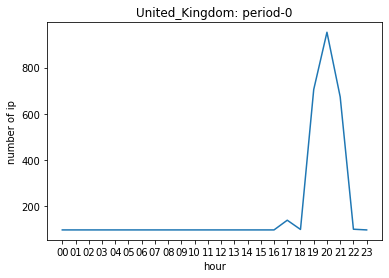

[97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 139, 99, 705, 953, 673, 100, 97]


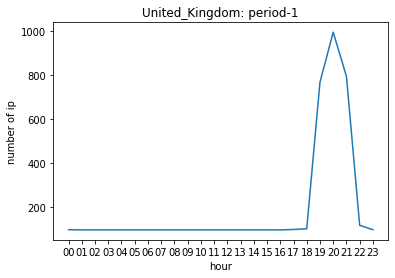

[98, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 99, 102, 769, 996, 795, 118, 98]

Figure 6.1: The Number of IPs in the UK of each hour


In [16]:
# Figure 6.1: The Number of IPs in the UK of each hour

def get_num_ip_hour(data_choose, period_choose):
    num_ip_hour = dict()
    for hour in hour_axis:
        num_ip_hour[hour] = []
    for ip in data_choose:
        for time in data_choose[ip]:
            hour = time[11:13]
            if ip not in num_ip_hour[hour]:
                num_ip_hour[hour].append(ip)
    # plot - axis
    y_num_ip = []
    for hour in hour_axis:
        y_num_ip.append(len(num_ip_hour[hour]))
    # plot
    pyplot.title(f'{data_loc}: period-{period_choose}')
    pyplot.xlabel('hour')
    pyplot.ylabel('number of ip')

    pyplot.plot(hour_axis, y_num_ip)
    pyplot.show()
    print(y_num_ip)
    return 0

get_num_ip_hour(uk_data_period_0, 0)
get_num_ip_hour(uk_data_period_1, 1)

print('\nFigure 6.1: The Number of IPs in the UK of each hour')

In [17]:
# Figure 6.2: The Estimation Result of the CJS model without Clustering - the UK-0

# the plot is in the folder '../Result/p2_daily_plot/period_0/n_cluster_0.png'


n_cluster: 2
number of error rate > 100: 0
number of nan: 0

n_cluster: 3
number of error rate > 100: 0
number of nan: 0

n_cluster: 4
number of error rate > 100: 1
number of nan: 0

n_cluster: 5
number of error rate > 100: 3
number of nan: 0

n_cluster: 6
number of error rate > 100: 5
number of nan: 0

n_cluster: 7
number of error rate > 100: 5
number of nan: 0

n_cluster: 8
number of error rate > 100: 6
number of nan: 0


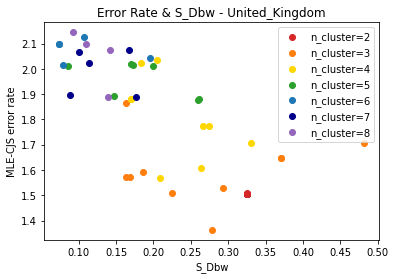

Figure 6.3: The CJS Result of the UK-0


In [18]:
# Figure 6.3: The CJS Result of the UK-0

def plot_cjs_S_Dbw_err(data_loc, period='', err_up_limit=math.inf):
    err_record, std_record, time_record = [], [], []
    for n_cluster in [2,3,4,5,6,7,8]:
        err_record.append([])
        std_record.append([])
        time_record.append([])
        for label in range(10):
            if period == '':
                file_path = f'../Result/{data_loc}/p2_est_result/n_cluster_{n_cluster}/label_{label}.txt'
            else:
                file_path = f'../Result/{data_loc}/p2_est_result/period_{period}/n_cluster_{n_cluster}/label_{label}.txt'
            with open(file_path) as f:
                lines = f.readlines()
            time_record[-1].append(float(lines[-1][10:]))
            if float(lines[0][5:]) > err_up_limit:
                err_record[-1].append(None)
                std_record[-1].append(None)
            else:
                err_record[-1].append(float(lines[0][5:]))
                std_record[-1].append(float(lines[1][5:]))

    # s_dbw_record
    s_dbw_record = []
    if period == '':
        s_dbw_file_path = f'../Result/{data_loc}/p0_cluster_result/s_dbw_record.csv'
    else:
        s_dbw_file_path = f'../Result/{data_loc}/p0_cluster_result/period_{period}/s_dbw_record.csv'
    df_sdbw = pd.read_csv(s_dbw_file_path)
    for n_cluster in range(7): # n_cluster=2~8
        s_dbw_record.append([])
        for label in range(10):
            s_dbw_record[-1].append(df_sdbw['S_Dbw'][n_cluster*10+label])

    # scatter plot - Error Rate & S_Dbw
    pyplot.title(f'Error Rate & S_Dbw - {data_loc}')
    pyplot.xlabel('S_Dbw')
    pyplot.ylabel('MLE-CJS error rate')
    colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']
    for n_cluster in range(7):
        _cluster = n_cluster+2
        pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
        print(f'\nn_cluster: {_cluster}')
        num_over_err_up_limit = 0
        num_is_nan = 0
        for label in range(10):
            if err_record[n_cluster][label] is None:
                num_over_err_up_limit += 1
            elif np.isnan(err_record[n_cluster][label]):
                num_is_nan += 1
        print(f'number of error rate > {err_up_limit}: {num_over_err_up_limit}')
        print(f'number of nan: {num_is_nan}')
    pyplot.legend()
    pyplot.show()
    
    return err_record, std_record, time_record, s_dbw_record

# get records and scatter plot of S_Dbw Score & Error Rate
uk_km_err_record_p0, uk_km_std_record_p0, uk_km_time_record_p0, uk_km_s_dbw_record_p0 = plot_cjs_S_Dbw_err(data_loc='United_Kingdom', 
                                                                                                          period=0, err_up_limit=100)
print('Figure 6.3: The CJS Result of the UK-0')

In [19]:
# Figure 6.4: The Estimation Result of the CJS model without Clustering - the UK-1

# the plot is in the folder '../Result/p2_daily_plot/period_1/n_cluster_0.png'


n_cluster: 2
number of error rate > 100: 0
number of nan: 0

n_cluster: 3
number of error rate > 100: 0
number of nan: 0

n_cluster: 4
number of error rate > 100: 1
number of nan: 0

n_cluster: 5
number of error rate > 100: 1
number of nan: 0

n_cluster: 6
number of error rate > 100: 4
number of nan: 0

n_cluster: 7
number of error rate > 100: 4
number of nan: 0

n_cluster: 8
number of error rate > 100: 7
number of nan: 0


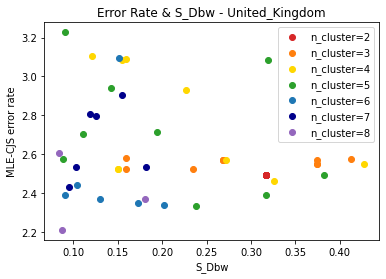

Figure 6.5: The CJS Result of the UK-1


In [20]:
# Figure 6.5: The CJS Result of the UK-1

# get records and scatter plot of S_Dbw Score & Error Rate
uk_km_err_record_p1, uk_km_std_record_p1, uk_km_time_record_p1, uk_km_s_dbw_record_p1 = plot_cjs_S_Dbw_err(data_loc='United_Kingdom', 
                                                                                                          period=1, err_up_limit=100)
print('Figure 6.5: The CJS Result of the UK-1')

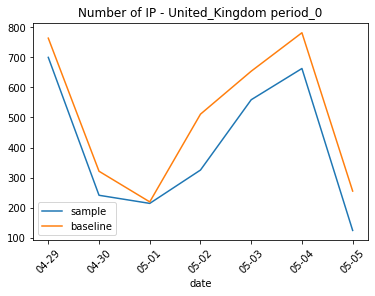

std/avg(sample_num): 215.8145462366866
total number of servers: 993
std/avg(sample_num): 0.5345724782932789
std/avg(baseline_num): 0.4426557416301395


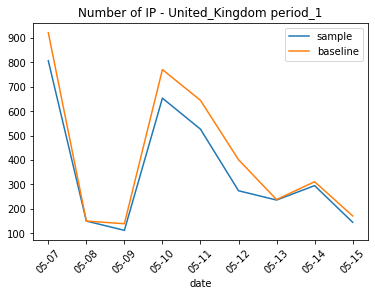

std/avg(sample_num): 233.55740563808945
total number of servers: 1050
std/avg(sample_num): 0.6574966064256507
std/avg(baseline_num): 0.6619212056283279

Figure 6.6: The Number of IPs in Each Date - the UK


In [21]:
# Figure 6.6: The Number of IPs in Each Date - the UK

def plot_num_ip_date(data_choose, data_loc, period_choose=''):
    if data_loc == 'United_Kingdom':
        sample_hour = '20'
    elif data_loc == 'Netherlands' or data_loc == 'France' or data_loc == 'Germany':
        sample_hour = '19'
    elif data_loc == 'us_period_0' or data_loc == 'us_period_0' or data_loc == 'us':
        sample_hour = '00'

    date_axis, sample_num, baseline_num, sample_ratio = baseline_sample_ip_num_dates(data_choose, sample_hour)
    plot_2_line(title='Number of IP',
              region=data_loc, period=period_choose,
              x_axis=date_axis, y1_axis=sample_num, y2_axis=baseline_num, 
              x_label='date', y1_label='sample', y2_label='baseline', x_rotation=True)
    print(f'std/avg(sample_num): {np.std(np.array(sample_num))}')
    print(f'total number of servers: {len(data_choose)}')
    print(f'std/avg(sample_num): {np.std(np.array(sample_num))/np.mean(np.array(sample_num))}')
    print(f'std/avg(baseline_num): {np.std(np.array(baseline_num))/np.mean(np.array(baseline_num))}')
    return 0

# plot and get results
data_loc = 'United_Kingdom'
plot_num_ip_date(uk_data_period_0, data_loc, 'period_0')
plot_num_ip_date(uk_data_period_1, data_loc, 'period_1')

print('\nFigure 6.6: The Number of IPs in Each Date - the UK')

In [22]:
# prepare calculate Std/Avg - each cluster

In [23]:
# data record for every dataset (UK, FR, NL, GER)
set_ip_trans_count_dict = dict()
set_ip_date_dict = dict()
set_baseline_ip_sum = dict()
set_s_dbw_record = dict()
set_dates = dict()
set_rm_s_dbw_record = dict() # for random clustering results

In [24]:
# hour_period - n_period=3, slide_hour=0
hour_period = [['00', '01', '02', '03', '04', '05', '06', '07'], 
               ['08', '09', '10', '11', '12', '13', '14', '15'], 
               ['16', '17', '18', '19', '20', '21', '22', '23']]

In [25]:
# dates for get_p1_caputure_history()
set_dates['United_Kingdom'] = [uk_period_0, uk_period_1]

In [26]:
# caculate baseline - number of servers in one date

def get_baseline_ip_sum(data_choose):
    _ip_date_dict = dict()
    for ip in data_choose:
        for time in data_choose[ip]:
            date = time[5:10]
            if date not in _ip_date_dict:
                _ip_date_dict[date] = [ip]
            elif ip not in _ip_date_dict[date]:
                _ip_date_dict[date].append(ip)
    # baseline
    _baseline_ip_sum = []
    for date in sorted(_ip_date_dict):
        _baseline_ip_sum.append(len(_ip_date_dict[date]))
    return _ip_date_dict, _baseline_ip_sum

uk_ip_date_dict_p0, uk_baseline_ip_sum_p0 = get_baseline_ip_sum(uk_data_period_0)
uk_ip_date_dict_p1, uk_baseline_ip_sum_p1 = get_baseline_ip_sum(uk_data_period_1)

set_baseline_ip_sum['United_Kingdom'] = [uk_baseline_ip_sum_p0, uk_baseline_ip_sum_p1]
set_ip_date_dict['United_Kingdom'] = [uk_ip_date_dict_p0, uk_ip_date_dict_p1]

In [27]:
# s_dbw_record

def get_s_dbw_record(data_loc, period_choose=0, label_amount=10, random_path=''):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    if random_path != '':
        random_path = '/random_nc_2to8'
    _s_dbw_record = []
    s_dbw_file_path = f'../Result/{data_loc}{random_path}/p0_cluster_result/{period_path}s_dbw_record.csv'
    df_sdbw = pd.read_csv(s_dbw_file_path)
    df_sdbw.head()
    for n_cluster in range(7): # n_cluster=2~8
        for label in range(label_amount):
            _s_dbw_record.append(df_sdbw['S_Dbw'][n_cluster*label_amount+label])
    return _s_dbw_record

uk_s_dbw_record_p0 = get_s_dbw_record('United_Kingdom', period_choose=0, label_amount=10)
uk_s_dbw_record_p1 = get_s_dbw_record('United_Kingdom', period_choose=1, label_amount=10)

set_s_dbw_record['United_Kingdom'] = [uk_s_dbw_record_p0, uk_s_dbw_record_p1]

In [28]:
# caculate 3-period transaction count for each IP

def get_ip_periods_count(ip, ip_time, hour_period=hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]: # hour = time[11:13]
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
    return hour_count

def get_ip_trans_count_dict(data_choose):
    _ip_trans_count_dict = dict()
    for ip in data_choose:
        _ip_trans_count_dict[ip] = get_ip_periods_count(ip=ip, ip_time=data_choose)
    return _ip_trans_count_dict
    
uk_ip_trans_count_dict_p0 = get_ip_trans_count_dict(uk_data_period_0)
uk_ip_trans_count_dict_p1 = get_ip_trans_count_dict(uk_data_period_1)

set_ip_trans_count_dict['United_Kingdom'] = [uk_ip_trans_count_dict_p0, uk_ip_trans_count_dict_p1]

In [29]:
# caculate baseline in classes
def baseline_class(data_loc, n_cluster, label, period_choose='', random_path=''):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    if random_path != '':
        random_path = '/random_nc_2to8'
    id_index_path = f'../Result/{data_loc}{random_path}/p1_capture_history/{period_path}ip_index.txt'
    with open(id_index_path) as f:
        ip_index = f.readlines()
    group_path = f'../Result/{data_loc}{random_path}/p1_capture_history/{period_path}n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
    if period_choose == '':
        ip_date_dict = set_ip_date_dict[data_loc][0]
    else:
        ip_date_dict = set_ip_date_dict[data_loc][period_choose]
    baseline_ip_num_class = []
    for date in sorted(ip_date_dict):
        baseline_ip_num_class.append([]) # new date
        for i in range(n_cluster):
            baseline_ip_num_class[-1].append(0) # each class number
        for i in range(len(ip_index)):
            ip = ip_index[i][:-1] # last two is '\n'
            group = int(groups[i][5]) # class0, class1, ...
            if ip in ip_date_dict[date]:
                baseline_ip_num_class[-1][group] += 1
                
    out_baseline_ip_num_class = []
    for _class in range(n_cluster):
        out_baseline_ip_num_class.append([])
        for date in range(len(baseline_ip_num_class)):
            out_baseline_ip_num_class[-1].append(baseline_ip_num_class[date][_class])
            
    # ip index for each class
    baseline_ip_index_class = []
    for i in range(n_cluster):
        baseline_ip_index_class.append([])
    for i in range(len(ip_index)):
        ip = ip_index[i][:-1] # last two is '\n'
        group = int(groups[i][5]) # class0, class1, ...
        baseline_ip_index_class[group].append(ip)
    return out_baseline_ip_num_class, baseline_ip_index_class

In [30]:
# Get the capture_p from R
def r_label_2_p2(data_loc, n_cluster, label, period_choose='', random_path=''):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    if random_path != '':
        random_path = '/random_nc_2to8'
    file_path = f'../Result/{data_loc}{random_path}/R_capture_probability/{period_path}n_cluster_{n_cluster}/r_{label}.txt'
    with open(file_path) as f:
        lines = f.readlines()
    # locate the p
    start=100000
    end=0
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for i in range(len(lines)):
        if lines[i][:2] == '$p':
            start=i+1
        elif lines[i] == lines[-3]:
            end=i
    CJS_time_use = float(lines[-1][19:-6])
    # record class, time, est
    class_loc, time_loc = 0,0
    for i in range(len(lines[start])):
        if lines[start][i]=='c': # cluster
            if lines[start][i+1]=='l' and lines[start][i+6]=='r':
                class_loc=i+6
        elif lines[start][i]=='t': # time
            if lines[start][i+1]=='i': # avoid 'estimate'
                if lines[start][i+3]=='e':
                    time_loc=i+3
    class_record = []
    time_record = []
    est_record = [] # ex: 6.197041e-01
    for line in lines[start+1:-2]:
        class_record.append(int(line[class_loc]))
        if line[time_loc-1] in numbers:
            time_record.append(int(line[time_loc-1:time_loc+1]))
        else:
            time_record.append(int(line[time_loc]))
        est_record.append(float(line[time_loc+6:-1]))
    
    clusters = np.unique(class_record)
    num_cluster = len(clusters)
    if period_choose == '':
        dates = set_dates[data_loc][0]
    else:
        dates = set_dates[data_loc][period_choose]
    time_len = len(dates)-1 # time = 2 ~ last date
    est_p_sort = [] # [[], []] num of class = num of list()
    for i in range(num_cluster):
        est_p_sort.append([])
        for j in range(time_len):
            est_p_sort[-1].append(0) # est num will be 'INF' if append '0' and some data not load 
    for i in range(len(time_record)):
        est_p_sort[class_record[i]][time_record[i]-2] = est_record[i]
    return est_p_sort, CJS_time_use


In [31]:
# Get the capture history from p1
def get_p1_caputure_history(data_loc, n_cluster, label, period_choose='', random_path=''):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    if random_path != '':
        random_path = '/random_nc_2to8'
    label_path = f'../Result/{data_loc}{random_path}/p1_capture_history/{period_path}n_cluster_{n_cluster}/label_{label}.txt'
    with open(label_path) as f:
        chs = f.readlines()
    group_path = f'../Result/{data_loc}{random_path}/p1_capture_history/{period_path}n_cluster_{n_cluster}/group_label_{label}.txt'
    with open(group_path) as f:
        groups = f.readlines()
    ch_in_class = [] # [[capture_history in class-0], [capture_history in class-1], ...]
    for i in range(n_cluster):
        ch_in_class.append([])
    for i in range(len(chs)):
        group = int(groups[i][5])
        ch_in_class[group].append(chs[i][:-1]) # last 2 is \n
        
    sum_ch_in_class = [] # [[sample number in class-0], [sample number in class-1], ...]
    if period_choose == '':
        dates = set_dates[data_loc][0]
    else:
        dates = set_dates[data_loc][period_choose]
    for _class in range(len(ch_in_class)):
        sum_class = []
        for date in range(len(dates)):
            sum_class.append(0)
            for j in range(len(ch_in_class[_class])):
                sum_class[date] += int(ch_in_class[_class][j][date]) # date
        sum_ch_in_class.append(sum_class)
    return sum_ch_in_class, ch_in_class

In [33]:
# for each cluster: n_cluster, cluster_err, std/avg, cluster_size
# for each clustering result: mean_std/avg, max_std/avg, min_cluster_size, min_cluster_err

def get_alternative_metric(data_loc, data_choose, period_choose='', label_amount=10, err_up_limit=math.inf, random_path=''):
    n_clusters = [2,3,4,5,6,7,8]
    data_cluster_df = pd.DataFrame(columns = ['n_cluster', 'cluster_err', 'std/avg', 'cluster_size'], 
                                   index=list(range(label_amount*(np.sum(n_clusters)))))
    data_df = pd.DataFrame(columns = ['n_cluster', 'err', 'mean_std/avg', 'max_std/avg', 'min_cluster_size', 'min_cluster_err'],
                           index=list(range(7*label_amount)))
    if period_choose == '':
        ip_trans_count_dict = set_ip_trans_count_dict[data_loc][0]
        baseline_ip_sum = set_baseline_ip_sum[data_loc][0]
        if random_path != '': s_dbw_record = set_rm_s_dbw_record[data_loc][0]
        else: s_dbw_record = set_s_dbw_record[data_loc][0]
    else:
        ip_trans_count_dict = set_ip_trans_count_dict[data_loc][period_choose]
        baseline_ip_sum = set_baseline_ip_sum[data_loc][period_choose]
        if random_path != '': s_dbw_record = set_rm_s_dbw_record[data_loc][period_choose]
        else: s_dbw_record = set_s_dbw_record[data_loc][period_choose]

    # min_class_size for each clustering result
    min_class_size = []
    err_record = []
    min_cluster_bias_proportion = []
    min_cluster_err = []

    # err & std/avg for each clusters
    mean_class_err_record = []
    std_avg_sample_num_record = []
    cluster_size_record = []
    index = 0 # for dataFrame
    for n_cluster in n_clusters:
        mean_class_err_record.append([])
        std_avg_sample_num_record.append([])
        cluster_size_record.append([])
        for label in range(label_amount):
            # for each clustering result, it contains 'n' mean_class_err, std_avg_sample_num, and cluster_size (n=2~8)
            mean_class_err_record[-1].append([])
            std_avg_sample_num_record[-1].append([])
            cluster_size_record[-1].append([])

            baseline_num_class, class_ip_index = baseline_class(data_loc, n_cluster, label, period_choose, random_path=random_path)
            baseline_num_class = np.array(baseline_num_class)

            # estimation number in class
            est_p, _ = r_label_2_p2(data_loc, n_cluster, label, period_choose, random_path=random_path)
            sum_ch, ch_in_class = get_p1_caputure_history(data_loc, n_cluster, label, period_choose, random_path=random_path)
            est_p, sum_ch = np.array(est_p), np.array(sum_ch)
            est_num_class = sum_ch[:, 1:] / est_p
            err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]

            # total est number
            est_sum = np.sum(est_num_class, axis=0)
            class_sizes = []
            err = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
            if err <= err_up_limit:
                for _class in range(n_cluster):
                    class_sizes.append(len(class_ip_index[_class]))
                    mean_class_err_record[-1][-1].append(np.mean(err_class[_class]))
                    std_avg_sample_num_record[-1][-1].append(np.std(sum_ch[_class])/np.mean(sum_ch[_class]))
                    cluster_size_record[-1][-1].append(len(class_ip_index[_class]))

                    # dataFrame
                    data_cluster_df['n_cluster'][index] = n_cluster
                    data_cluster_df['cluster_err'][index] = mean_class_err_record[-1][-1][-1]
                    data_cluster_df['std/avg'][index] = std_avg_sample_num_record[-1][-1][-1]
                    data_cluster_df['cluster_size'][index] = len(class_ip_index[_class])
                    index += 1
                min_class_size.append(min(class_sizes))
                err_record.append(np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2]))
                # bias in min cluster
                min_cluster_index = class_sizes.index(min(class_sizes))
                bias_class = np.abs(est_num_class[:,1:-2] - baseline_num_class[:,2:-2])
                nan_in_bias_class = False
                for bias in bias_class[min_cluster_index]:
                    if np.isnan(bias):
                        nan_in_bias_class = True
                if not nan_in_bias_class:
                    min_cluster_bias_proportion.append(np.mean(bias_class[min_cluster_index]/est_sum[1:-2]))
                    min_cluster_err.append(np.mean(err_class[min_cluster_index]))
                data_df_index = (n_cluster-2)*label_amount + label
                data_df['n_cluster'][data_df_index] = n_cluster
                data_df['err'][data_df_index] = np.mean(np.abs( est_sum[1:-2] - baseline_ip_sum[2:-2] ) / baseline_ip_sum[2:-2])
                data_df['mean_std/avg'][data_df_index] = np.mean(std_avg_sample_num_record[-1][-1])
                data_df['max_std/avg'][data_df_index] = max(std_avg_sample_num_record[-1][-1])
                data_df['min_cluster_size'][data_df_index] = min(class_sizes)
                data_df['min_cluster_err'][data_df_index] = np.mean(err_class[min_cluster_index])

    # Delete these row indexes from dataFrame
    indexNames = data_cluster_df[ data_cluster_df['cluster_err'] == 'None' ].index
    if len(indexNames) != 0:
        print(f'drop cluster_df index (cluster_err==None): {indexNames}')
    data_cluster_df.drop(indexNames , inplace=True)
    return data_cluster_df, data_df #, mean_class_err_record, std_avg_sample_num_record

In [34]:
# get df for alternative_metric

data_loc = 'United_Kingdom'
uk_data_cluster_df_p0, uk_data_df_p0 = get_alternative_metric(data_loc, uk_data_period_0, period_choose=0, 
                                                              label_amount=10, err_up_limit=100)
uk_data_cluster_df_p1, uk_data_df_p1 = get_alternative_metric(data_loc, uk_data_period_1, period_choose=1, 
                                                              label_amount=10, err_up_limit=100)

print('Finish get_alternative_metric')

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:51: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]


Finish get_alternative_metric


In [35]:
# plot function

def plot_StdAvg_ClusterErr(data_cluster_df, data_loc_period):
    pyplot.title(f'Std/Avg & Cluster Error Rate - {data_loc_period}')
    pyplot.xlabel('Std/Avg - number of sample servers')
    pyplot.ylabel('cluster error rate')

    colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']

    for n_cluster in range(7):
        _cluster = n_cluster+2
        label_index = data_cluster_df.index[data_cluster_df['n_cluster']==_cluster].tolist()
        _std_avg = [data_cluster_df['std/avg'][label] for label in label_index]
        _class_err = [data_cluster_df['cluster_err'][label] for label in label_index]
        pyplot.scatter(_std_avg, _class_err, color=colors[n_cluster], label=f'n_cluster={_cluster}')

    pyplot.legend()
    pyplot.show()
    return 0

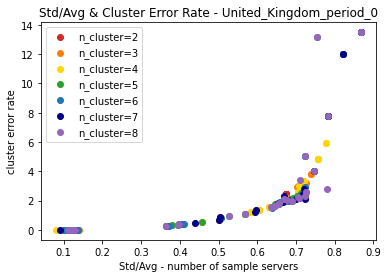

Figure 6.7: Std/Avg and Cluster Error Rate in K-Means - the UK-0


In [36]:
# Figure 6.7: Std/Avg and Cluster Error Rate in K-Means - the UK-0

plot_StdAvg_ClusterErr(uk_data_cluster_df_p0, 'United_Kingdom_period_0')

print('Figure 6.7: Std/Avg and Cluster Error Rate in K-Means - the UK-0')

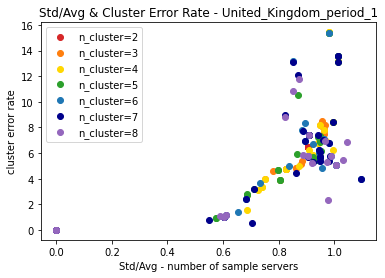

Figure 6.8: Std/Avg and Cluster Error Rate in K-Means - the UK-1


In [37]:
# Figure 6.8: Std/Avg and Cluster Error Rate in K-Means - the UK-1

plot_StdAvg_ClusterErr(uk_data_cluster_df_p1, 'United_Kingdom_period_1')

print('Figure 6.8: Std/Avg and Cluster Error Rate in K-Means - the UK-1')

In [38]:
# 6.2.3 CJS Model with Random Clustering

In [39]:
# err_record, std_record, time_record, s_dbw_record

data_loc = 'United_Kingdom'
# label_number_each_n_cluster = 20
err_up_limit = math.inf #10**2

def get_err_std_time_rm(data_loc, period_choose='', label_amount=20, err_up_limit=math.inf):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    err_record, std_record, time_record = [], [], []
    for n_cluster in [2,3,4,5,6,7,8]:
        err_record.append([])
        std_record.append([])
        time_record.append([])
        for label in range(label_amount):
            file_path = f'../Result/{data_loc}/random_nc_2to8/p2_est_result/{period_path}n_cluster_{n_cluster}/label_{label}.txt'
            with open(file_path) as f:
                lines = f.readlines()
            time_record[-1].append(float(lines[-1][10:]))
            if float(lines[0][5:]) > err_up_limit:
                err_record[-1].append(None)
                std_record[-1].append(None)
            else:
                err_record[-1].append(float(lines[0][5:]))
                std_record[-1].append(float(lines[1][5:]))
    return err_record, std_record, time_record

uk_rm_err_record_p0, uk_rm_std_record_p0, uk_rm_time_record_p0 = get_err_std_time_rm(data_loc, period_choose=0)
uk_rm_err_record_p1, uk_rm_std_record_p1, uk_rm_time_record_p1 = get_err_std_time_rm(data_loc, period_choose=1)        
print('finish err_record, std_record, time_record')

def get_sdbw_rm(data_loc, period_choose='', label_amount=20, err_up_limit=math.inf):
    if period_choose != '':
        period_path = f'period_{period_choose}/'
    else: period_path = ''
    s_dbw_record = []
    s_dbw_file_path = f'../Result/{data_loc}/random_nc_2to8/p0_cluster_result/{period_path}s_dbw_record.csv'
    df_sdbw = pd.read_csv(s_dbw_file_path)
    for n_cluster in range(7): # n_cluster=2~8
        s_dbw_record.append([])
        for label in range(label_amount):
            s_dbw_record[-1].append(df_sdbw['S_Dbw'][n_cluster*label_amount+label])
    return s_dbw_record

uk_rm_s_dbw_record_p0 = get_sdbw_rm(data_loc, period_choose=0)
uk_rm_s_dbw_record_p1 = get_sdbw_rm(data_loc, period_choose=1)

set_rm_s_dbw_record['United_Kingdom'] = [uk_rm_s_dbw_record_p0, uk_rm_s_dbw_record_p1]

print('finish s_dbw_record')

finish err_record, std_record, time_record
finish s_dbw_record


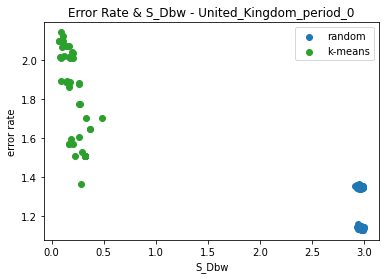

Figure 6.9: K-Means and Random Clustering - the UK-0


In [40]:
# Figure 6.9: K-Means and Random Clustering - the UK-0

data_loc_period =  'United_Kingdom_period_0'

pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(uk_rm_s_dbw_record_p0, uk_rm_err_record_p0, color='tab:blue', label='random')
pyplot.scatter(uk_km_s_dbw_record_p0, uk_km_err_record_p0, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.9: K-Means and Random Clustering - the UK-0')

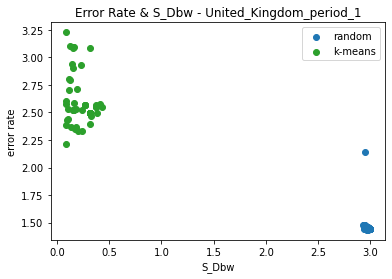

Figure 6.10: K-Means and Random Clustering - the UK-1


In [41]:
# Figure 6.10: K-Means and Random Clustering - the UK-1

data_loc_period =  'United_Kingdom_period_1'

pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(uk_rm_s_dbw_record_p1, uk_rm_err_record_p1, color='tab:blue', label='random')
pyplot.scatter(uk_km_s_dbw_record_p1, uk_km_err_record_p1, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.10: K-Means and Random Clustering - the UK-1')

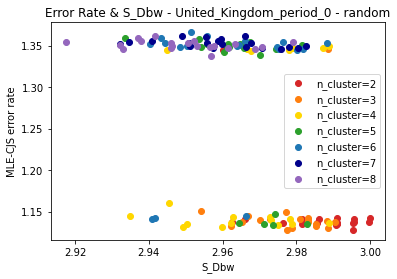

Figure 6.11: Error Rate and S_Dbw of Random Clustering - UK-0


In [42]:
# Figure 6.11: Error Rate and S_Dbw of Random Clustering - UK-0

data_loc_period =  'United_Kingdom_period_0'

def plot_rm_cjs_S_Dbw_err(data_loc_period, s_dbw_record, err_record, label_amout=20):    
    pyplot.title(f'Error Rate & S_Dbw - {data_loc_period} - random')
    pyplot.xlabel('S_Dbw')
    pyplot.ylabel('MLE-CJS error rate')
    colors = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'darkblue', 'tab:purple']
    for n_cluster in range(7):
        _cluster = n_cluster+2
        pyplot.scatter(s_dbw_record[n_cluster], err_record[n_cluster], color=colors[n_cluster], label=f'n_cluster={_cluster}')
        num_over_err_up_limit = 0
        num_is_nan = 0
        for label in range(label_amout):
            if err_record[n_cluster][label] is None:
                num_over_err_up_limit += 1
            elif np.isnan(err_record[n_cluster][label]):
                num_is_nan += 1
    pyplot.legend()
    pyplot.show()
    return 0

plot_rm_cjs_S_Dbw_err(data_loc_period, uk_rm_s_dbw_record_p0, uk_rm_err_record_p0)

print('Figure 6.11: Error Rate and S_Dbw of Random Clustering - UK-0')

In [43]:
# Table 6.5: Correlation Matrix - Random Clustering in UK-0

def get_rm_df(s_dbw_record, err_record, std_record, time_record, label_amount=20):
    random_data_df = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(7*label_amount)))

    for n_cluster in [2,3,4,5,6,7,8]:
        for label in range(label_amount):
            index = (n_cluster-2)*label_amount+label
            random_data_df['n_cluster'][index] = n_cluster
            random_data_df['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
            random_data_df['err'][index] = err_record[n_cluster-2][label]
            random_data_df['std'][index] = std_record[n_cluster-2][label]
            random_data_df['CJS_time'][index] = time_record[n_cluster-2][label]
            if err_record[n_cluster-2][label] is None:
                print(f'err is None: n_cluster={n_cluster}, label={label}')
                random_data_df['err'][index] = 'None'
                random_data_df['std'][index] = 'None'
            elif np.isnan(err_record[n_cluster-2][label]):
                print(f'err is nan: n_cluster={n_cluster}, label={label}')
                random_data_df['err'][index] = 'None'
                random_data_df['std'][index] = 'None'

    # Delete these row indexes from dataFrame
    indexNames = random_data_df[ random_data_df['err'] == 'None' ].index
    if len(indexNames) != 0:
        print(f'drop index (err=None): {indexNames}')
    random_data_df.drop(indexNames , inplace=True)

    mean_err = np.mean(random_data_df['err'])
    print(f'mean err: {mean_err}')
    max_time = max(random_data_df['CJS_time'])
    print(f'max CJS time: {max_time}')
    return random_data_df

uk_rm_random_data_df_p0 = get_rm_df(uk_rm_s_dbw_record_p0, uk_rm_err_record_p0, uk_rm_std_record_p0, uk_rm_time_record_p0)

print('\nTable 6.5: Correlation Matrix - Random Clustering in UK-0')
uk_rm_random_data_df_p0.astype('float64').corr()

mean err: 1.261363455929106
max CJS time: 6.92904

Table 6.5: Correlation Matrix - Random Clustering in UK-0


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.629361,0.766057,0.761490,0.969996
S_Dbw,-0.629361,1.000000,-0.481153,-0.499175,-0.609873
err,0.766057,-0.481153,1.000000,0.992447,0.664871
std,0.761490,-0.499175,0.992447,1.000000,0.658940
CJS_time,0.969996,-0.609873,0.664871,0.658940,1.000000


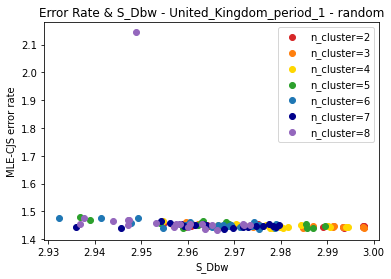

Figure 6.12: Error Rate and S_Dbw of Random Clustering - UK-1


In [44]:
# Figure 6.12: Error Rate and S_Dbw of Random Clustering - UK-1

data_loc_period =  'United_Kingdom_period_1'
plot_rm_cjs_S_Dbw_err(data_loc_period, uk_rm_s_dbw_record_p1, uk_rm_err_record_p1)

print('Figure 6.12: Error Rate and S_Dbw of Random Clustering - UK-1')

In [45]:
# Table 6.6: Correlation Matrix - Random Clustering in UK-1

uk_rm_random_data_df_p1 = get_rm_df(uk_rm_s_dbw_record_p1, uk_rm_err_record_p1, uk_rm_std_record_p1, uk_rm_time_record_p1)

print('\nTable 6.6: Correlation Matrix - Random Clustering in UK-1')
uk_rm_random_data_df_p1.astype('float64').corr()

mean err: 1.4552695980080632
max CJS time: 27.99465

Table 6.6: Correlation Matrix - Random Clustering in UK-1


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.502242,0.158932,0.051041,0.962506
S_Dbw,-0.502242,1.000000,-0.203827,-0.238953,-0.490109
err,0.158932,-0.203827,1.000000,0.842175,0.077103
std,0.051041,-0.238953,0.842175,1.000000,-0.013043
CJS_time,0.962506,-0.490109,0.077103,-0.013043,1.000000


In [46]:
# get df for alternative_metric - random clustering

data_loc = 'United_Kingdom'
uk_rm_data_cluster_df_p0, uk_rm_data_df_p0 = get_alternative_metric(data_loc, uk_data_period_0, period_choose=0, 
                                                              label_amount=20, err_up_limit=100, random_path=True)
uk_rm_data_cluster_df_p1, uk_rm_data_df_p1 = get_alternative_metric(data_loc, uk_data_period_1, period_choose=1, 
                                                              label_amount=20, err_up_limit=100, random_path=True)

print('Finish get_alternative_metric')

Finish get_alternative_metric


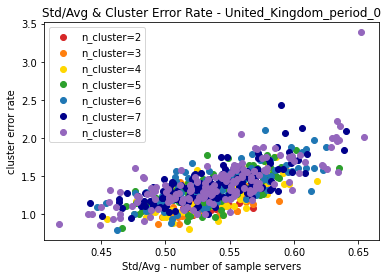

Figure 6.13: Std/Avg and Cluster Error Rate of Random Clustering - UK-0


In [47]:
# Figure 6.13: Std/Avg and Cluster Error Rate of Random Clustering - UK-0

data_loc_period =  'United_Kingdom_period_0'
plot_StdAvg_ClusterErr(uk_rm_data_cluster_df_p0, data_loc_period)

print('Figure 6.13: Std/Avg and Cluster Error Rate of Random Clustering - UK-0')

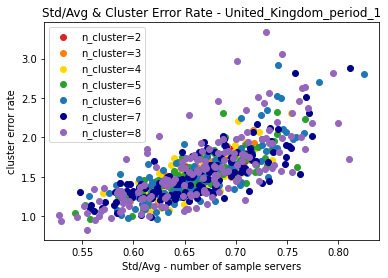

Figure 6.14: Std/Avg and Cluster Error Rate of Random Clustering - UK-1


In [48]:
# Figure 6.14: Std/Avg and Cluster Error Rate of Random Clustering - UK-1

data_loc_period =  'United_Kingdom_period_1'
plot_StdAvg_ClusterErr(uk_rm_data_cluster_df_p1, data_loc_period)

print('Figure 6.14: Std/Avg and Cluster Error Rate of Random Clustering - UK-1')

In [49]:
# 6.3 CJS Model in France

In [50]:
data_loc = 'France'
fr_ip_time = read_dataset_csv(data_loc)

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\3693111506.py:4: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)  # read csv


data_loc: France
num of total server: 1448
time cost: 32.06362867355347
the size of data 171046


In [51]:
# dataset
fr_period_0 = ["2021-04-29", "2021-04-30", "2021-05-01", "2021-05-02", "2021-05-03", "2021-05-04", "2021-05-05"]
fr_data_period_0 = get_ip_time(ip_data=fr_ip_time, period=fr_period_0)

fr_data_2021 = get_ip_time(ip_data=fr_ip_time, period='2021')

set_dates['France'] = [fr_period_0]

print(f'data_loc: {data_loc}')
for key, value in fr_data_2021.items():
    print(key)
    print(f'first 5 transaction: {value[0:5]}, \nlast 5 transaction: {value[-5:]}')
    print(f'transaction count: {len(value)}')
    break
print(f'len(uk_data_period_0): {len(fr_data_period_0)}')

data_loc: France
99.181.64.105
first 5 transaction: ['2021-04-15T200101', '2021-04-17T185520', '2021-04-17T185941', '2021-04-17T191839', '2021-04-17T192917'], 
last 5 transaction: ['2021-05-11T203900', '2021-05-11T203900', '2021-05-09T200403', '2021-05-10T192940', '2021-05-10T204749']
transaction count: 109
len(uk_data_period_0): 1138


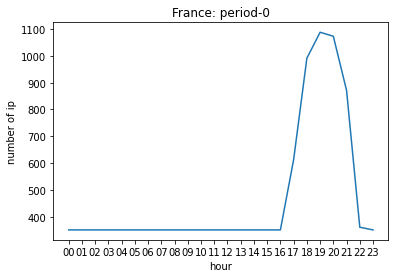

[351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 613, 991, 1088, 1073, 871, 361, 351]
The Number of IPs in the France of each hour


In [52]:
# set sample hour = 19

get_num_ip_hour(fr_data_period_0, 0)

print('The Number of IPs in the France of each hour')

In [53]:
# Figure 6.15: The Estimation Result of the CJS model without Clustering - France

# the plot is in the folder '../Result/France/p2_daily_plot/n_cluster_0.png'


n_cluster: 2
number of error rate > 100: 0
number of nan: 0

n_cluster: 3
number of error rate > 100: 0
number of nan: 0

n_cluster: 4
number of error rate > 100: 0
number of nan: 0

n_cluster: 5
number of error rate > 100: 0
number of nan: 0

n_cluster: 6
number of error rate > 100: 0
number of nan: 0

n_cluster: 7
number of error rate > 100: 0
number of nan: 0

n_cluster: 8
number of error rate > 100: 0
number of nan: 0


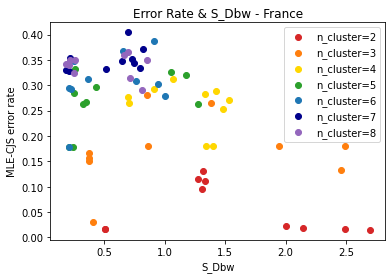

Figure 6.16: The CJS Result of France


In [54]:
# Figure 6.16: The CJS Result of France

# get records and scatter plot of S_Dbw Score & Error Rate
fr_km_err_record, fr_km_std_record, fr_km_time_record, fr_km_s_dbw_record = plot_cjs_S_Dbw_err(data_loc='France', 
                                                                                                err_up_limit=100)
print('Figure 6.16: The CJS Result of France')

In [55]:
# Table 6.7: Correlation Matrix - France

def get_data_df(s_dbw_record, err_record, std_record, time_record, label_amount=10):
    data_df = pd.DataFrame(columns = ['n_cluster', 'S_Dbw', 'err', 'std', 'CJS_time'], index=list(range(7*label_amount)))

    for n_cluster in [2,3,4,5,6,7,8]:
        for label in range(label_amount):
            index = (n_cluster-2)*label_amount+label
            data_df['n_cluster'][index] = n_cluster
            data_df['S_Dbw'][index] = s_dbw_record[n_cluster-2][label]
            data_df['err'][index] = err_record[n_cluster-2][label]
            data_df['std'][index] = std_record[n_cluster-2][label]
            data_df['CJS_time'][index] = time_record[n_cluster-2][label]
            if err_record[n_cluster-2][label] is None:
                print(f'err is None: n_cluster={n_cluster}, label={label}')
                data_df['err'][index] = 'None'
                data_df['std'][index] = 'None'
            elif np.isnan(err_record[n_cluster-2][label]):
                print(f'err is nan: n_cluster={n_cluster}, label={label}')
                data_df['err'][index] = 'None'
                data_df['std'][index] = 'None'
    # Delete these row indexes from dataFrame
    indexNames = data_df[ data_df['err'] == 'None' ].index
    if len(indexNames) != 0:
        print(f'drop index (err=None): {indexNames}')
    data_df.drop(indexNames , inplace=True)
    return data_df

fr_data_df = get_data_df(fr_km_s_dbw_record, fr_km_err_record, fr_km_std_record, fr_km_time_record, label_amount=10)

print('Table 6.7: Correlation Matrix - France')
fr_data_df.astype('float64').corr()

Table 6.7: Correlation Matrix - France


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.571554,0.832937,0.750993,0.958401
S_Dbw,-0.571554,1.000000,-0.487071,-0.462512,-0.461262
err,0.832937,-0.487071,1.000000,0.948909,0.783359
std,0.750993,-0.462512,0.948909,1.000000,0.679739
CJS_time,0.958401,-0.461262,0.783359,0.679739,1.000000


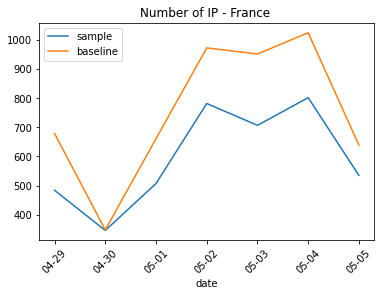

std/avg(sample_num): 158.57734866683856
total number of servers: 1138
std/avg(sample_num): 0.26664459300213067
std/avg(baseline_num): 0.29786048605826443
Figure 6.17: The Number of IPs in Each Date - France


In [56]:
# Figure 6.17: The Number of IPs in Each Date - France

data_loc = 'France'
plot_num_ip_date(fr_data_period_0, data_loc)

print('Figure 6.17: The Number of IPs in Each Date - France')

In [57]:
fr_ip_date_dict, fr_baseline_ip_sum = get_baseline_ip_sum(fr_data_period_0)
set_baseline_ip_sum['France'] = [fr_baseline_ip_sum]
set_ip_date_dict['France'] = [fr_ip_date_dict]

fr_s_dbw_record = get_s_dbw_record('France', period_choose='', label_amount=10)
set_s_dbw_record['France'] = [fr_s_dbw_record]

fr_ip_trans_count_dict = get_ip_trans_count_dict(fr_data_period_0)
set_ip_trans_count_dict['France'] = [fr_ip_trans_count_dict]

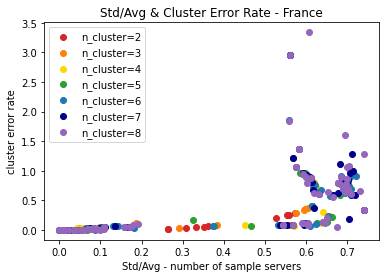

Figure 6.18: Std/Avg and Cluster Error Rate in K-Means - France


In [58]:
# Figure 6.18: Std/Avg and Cluster Error Rate in K-Means - France

data_loc = 'France'
fr_data_cluster_df, fr_data_df = get_alternative_metric(data_loc, fr_data_period_0, period_choose='', 
                                                              label_amount=10, err_up_limit=100)

plot_StdAvg_ClusterErr(fr_data_cluster_df, 'France')

print('Figure 6.18: Std/Avg and Cluster Error Rate in K-Means - France')

In [59]:
# ch 6.3.3 CJS Model with Random Clustering

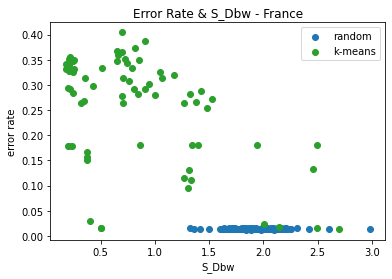

Figure 6.19: K-Means and Random Clustering - France


In [60]:
# Figure 6.19: K-Means and Random Clustering - France

data_loc = 'France'
fr_rm_err_record, fr_rm_std_record, fr_rm_time_record = get_err_std_time_rm(data_loc, period_choose='')

fr_rm_s_dbw_record = get_sdbw_rm(data_loc, period_choose='')
set_rm_s_dbw_record['France'] = [fr_rm_s_dbw_record]


data_loc_period =  'France'
pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(fr_rm_s_dbw_record, fr_rm_err_record, color='tab:blue', label='random')
pyplot.scatter(fr_km_s_dbw_record, fr_km_err_record, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.19: K-Means and Random Clustering - France')

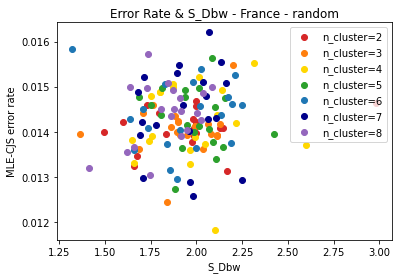

Figure 6.20: Error Rate and S_Dbw of Random Clustering - France


In [61]:
# Figure 6.20: Error Rate and S_Dbw of Random Clustering - France

data_loc_period =  'France'
plot_rm_cjs_S_Dbw_err(data_loc_period, fr_rm_s_dbw_record, fr_rm_err_record)

print('Figure 6.20: Error Rate and S_Dbw of Random Clustering - France')

In [62]:
# Table 6.8: Correlation Matrix - Random Clustering in France

fr_rm_random_data_df = get_rm_df(fr_rm_s_dbw_record, fr_rm_err_record, fr_rm_std_record, fr_rm_time_record)

print('\nTable 6.8: Correlation Matrix - Random Clustering in France')
fr_rm_random_data_df.astype('float64').corr()

mean err: 0.014257754971468948
max CJS time: 11.11386

Table 6.8: Correlation Matrix - Random Clustering in France


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.123103,0.189012,-0.206617,0.969766
S_Dbw,-0.123103,1.000000,0.065538,0.035408,-0.164432
err,0.189012,0.065538,1.000000,-0.094600,0.168223
std,-0.206617,0.035408,-0.094600,1.000000,-0.188054
CJS_time,0.969766,-0.164432,0.168223,-0.188054,1.000000


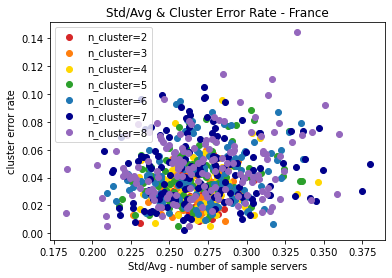

Figure 6.21: Std/Avg and Cluster Error Rate of Random Clustering - France


In [63]:
# Figure 6.21: Std/Avg and Cluster Error Rate of Random Clustering - France

data_loc = 'France'
fr_rm_data_cluster_df, fr_rm_data_df = get_alternative_metric(data_loc, fr_data_period_0, period_choose='', 
                                                              label_amount=20, err_up_limit=100, random_path=True)
data_loc_period =  'France'
plot_StdAvg_ClusterErr(fr_rm_data_cluster_df, data_loc_period)

print('Figure 6.21: Std/Avg and Cluster Error Rate of Random Clustering - France')

In [64]:
# 6.4 CJS Model in the Netherlands

In [65]:
data_loc = 'Netherlands'
nl_ip_time = read_dataset_csv(data_loc)

data_loc: Netherlands
num of total server: 565
time cost: 27.45133948326111
the size of data 140551


In [66]:
# dataset - period
nl_period_0 = ['2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27']
nl_period_1 = ['2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13']
    
# get data
nl_data_period_0 = get_ip_time(ip_data=nl_ip_time, period=nl_period_0)
nl_data_period_1 = get_ip_time(ip_data=nl_ip_time, period=nl_period_1)

nl_data_2021 = get_ip_time(ip_data=ip_time, period='2021')

set_dates['Netherlands'] = [nl_period_0, nl_period_1]

print(f'data_loc: {data_loc}')
for key, value in nl_data_period_0.items():
    print(key)
    print(f'first 5 transaction: {value[0:5]}, \nlast 5 transaction: {value[-5:]}')
    print(f'transaction count: {len(value)}')
    break

data_loc: Netherlands
52.223.200.83
first 5 transaction: ['2021-06-18T031921', '2021-06-18T032204', '2021-06-18T032609', '2021-06-18T032758', '2021-06-18T033122'], 
last 5 transaction: ['2021-06-27T050254', '2021-06-27T050749', '2021-06-27T051040', '2021-06-27T051414', '2021-06-27T051525']
transaction count: 82013


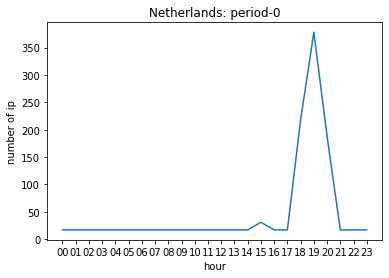

[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 31, 17, 17, 218, 378, 188, 17, 17, 17]


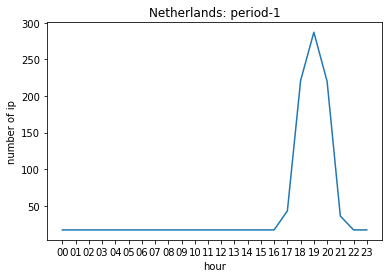

[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 43, 221, 287, 220, 36, 17, 17]
The Number of IPs in the Netherlands of each hour


In [67]:
# set sample hour = 19

get_num_ip_hour(nl_data_period_0, 0)
get_num_ip_hour(nl_data_period_1, 1)

print('The Number of IPs in the Netherlands of each hour')

In [68]:
# Figure 6.22: The Estimation Result of the CJS model without Clustering - Netherlands-0

# the plot is in the folder '../Result/Netherlands/p2_daily_plot/period_0/n_cluster_0.png'

In [69]:
# Figure 6.23: The Estimation Result of the CJS model without Clustering - Netherlands-1

# the plot is in the folder '../Result/Netherlands/p2_daily_plot/period_1/n_cluster_0.png'


n_cluster: 2
number of error rate > 100: 1
number of nan: 0

n_cluster: 3
number of error rate > 100: 9
number of nan: 0

n_cluster: 4
number of error rate > 100: 10
number of nan: 0

n_cluster: 5
number of error rate > 100: 10
number of nan: 0

n_cluster: 6
number of error rate > 100: 10
number of nan: 0

n_cluster: 7
number of error rate > 100: 10
number of nan: 0

n_cluster: 8
number of error rate > 100: 10
number of nan: 0


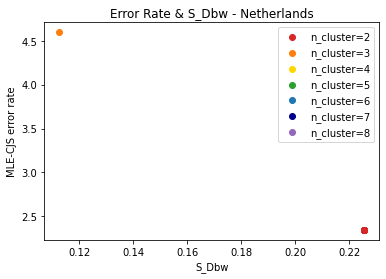

Figure 6.24: The CJS Result of the Netherlands - Netherlands-0


In [70]:
# Figure 6.24: The CJS Result of the Netherlands - Netherlands-0

# get records and scatter plot of S_Dbw Score & Error Rate
nl_km_err_record_p0, nl_km_std_record_p0, nl_km_time_record_p0, nl_km_s_dbw_record_p0 = plot_cjs_S_Dbw_err(data_loc='Netherlands', 
                                                                                                period=0, err_up_limit=100)
print('Figure 6.24: The CJS Result of the Netherlands - Netherlands-0')


n_cluster: 2
number of error rate > 100: 0
number of nan: 0

n_cluster: 3
number of error rate > 100: 10
number of nan: 0

n_cluster: 4
number of error rate > 100: 10
number of nan: 0

n_cluster: 5
number of error rate > 100: 10
number of nan: 0

n_cluster: 6
number of error rate > 100: 10
number of nan: 0

n_cluster: 7
number of error rate > 100: 10
number of nan: 0

n_cluster: 8
number of error rate > 100: 10
number of nan: 0


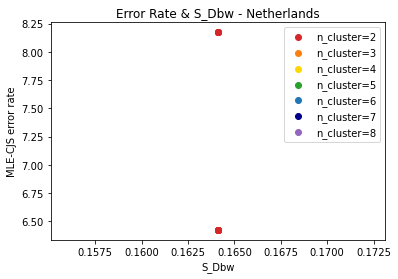

Figure 6.25: The CJS Result of the Netherlands - Netherlands-1


In [71]:
# Figure 6.25: The CJS Result of the Netherlands - Netherlands-1

# get records and scatter plot of S_Dbw Score & Error Rate
nl_km_err_record_p1, nl_km_std_record_p1, nl_km_time_record_p1, nl_km_s_dbw_record_p1 = plot_cjs_S_Dbw_err(data_loc='Netherlands', 
                                                                                                period=1, err_up_limit=100)
print('Figure 6.25: The CJS Result of the Netherlands - Netherlands-1')

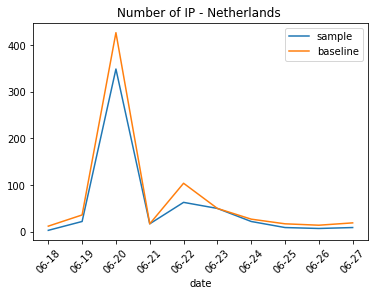

std/avg(sample_num): 99.69297868957473
total number of servers: 469
std/avg(sample_num): 1.8093099580685068
std/avg(baseline_num): 1.6751024724840453


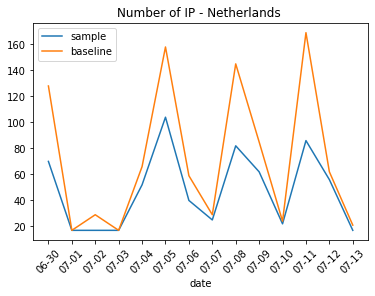

std/avg(sample_num): 28.79386626859751
total number of servers: 414
std/avg(sample_num): 0.6043690071369792
std/avg(baseline_num): 0.7453272928999678
Figure 6.26: The Number of IPs in Each Date - Netherlands


In [72]:
# Figure 6.26: The Number of IPs in Each Date - Netherlands

data_loc = 'Netherlands'
plot_num_ip_date(nl_data_period_0, data_loc)
plot_num_ip_date(nl_data_period_1, data_loc)

print('Figure 6.26: The Number of IPs in Each Date - Netherlands')

In [73]:
data_loc = 'Netherlands'
err_up_limit = 100
nl_rm_err_record_p0, nl_rm_std_record_p0, nl_rm_time_record_p0 = get_err_std_time_rm(data_loc, period_choose=0, err_up_limit=err_up_limit)
nl_rm_err_record_p1, nl_rm_std_record_p1, nl_rm_time_record_p1 = get_err_std_time_rm(data_loc, period_choose=1, err_up_limit=err_up_limit)

nl_rm_s_dbw_record_p0 = get_sdbw_rm(data_loc, period_choose=0)
nl_rm_s_dbw_record_p1 = get_sdbw_rm(data_loc, period_choose=1)

set_rm_s_dbw_record['Netherlands'] = [nl_rm_s_dbw_record_p0, nl_rm_s_dbw_record_p1]

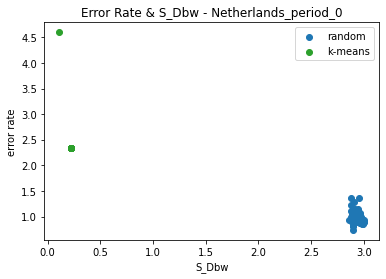

Figure 6.27: K-Means and Random Clustering - Netherlands-0


In [74]:
# Figure 6.27: K-Means and Random Clustering - Netherlands-0

data_loc_period =  'Netherlands_period_0'
pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(nl_rm_s_dbw_record_p0, nl_rm_err_record_p0, color='tab:blue', label='random')
pyplot.scatter(nl_km_s_dbw_record_p0, nl_km_err_record_p0, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.27: K-Means and Random Clustering - Netherlands-0')

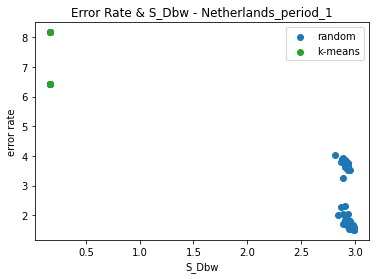

Figure 6.28: K-Means and Random Clustering - Netherlands-1


In [75]:
# Figure 6.28: K-Means and Random Clustering - Netherlands-1

data_loc_period =  'Netherlands_period_1'
pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(nl_rm_s_dbw_record_p1, nl_rm_err_record_p1, color='tab:blue', label='random')
pyplot.scatter(nl_km_s_dbw_record_p1, nl_km_err_record_p1, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.28: K-Means and Random Clustering - Netherlands-1')

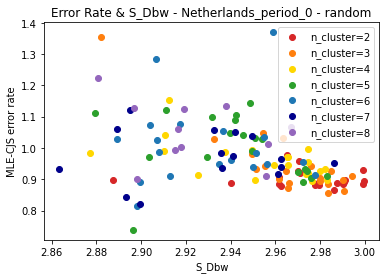

Figure 6.29: Error Rate and S_Dbw of Random Clustering - Netherlands-0


In [76]:
# Figure 6.29: Error Rate and S_Dbw of Random Clustering - Netherlands-0

data_loc_period =  'Netherlands_period_0'
plot_rm_cjs_S_Dbw_err(data_loc_period, nl_rm_s_dbw_record_p0, nl_rm_err_record_p0)

print('Figure 6.29: Error Rate and S_Dbw of Random Clustering - Netherlands-0')

In [77]:
# Table 6.9: Correlation Matrix - Random Clustering in Netherlands-0

nl_rm_random_data_df_p0 = get_rm_df(nl_rm_s_dbw_record_p0, nl_rm_err_record_p0, nl_rm_std_record_p0, nl_rm_time_record_p0)

print('\nTable 6.9: Correlation Matrix - Random Clustering in Netherlands-0')
nl_rm_random_data_df_p0.astype('float64').corr()

err is None: n_cluster=6, label=13
err is None: n_cluster=7, label=1
err is None: n_cluster=7, label=2
err is None: n_cluster=7, label=3
err is None: n_cluster=7, label=13
err is None: n_cluster=7, label=16
err is None: n_cluster=8, label=4
err is None: n_cluster=8, label=5
err is None: n_cluster=8, label=6
err is None: n_cluster=8, label=12
err is None: n_cluster=8, label=13
err is None: n_cluster=8, label=14
err is None: n_cluster=8, label=16
err is None: n_cluster=8, label=17
err is None: n_cluster=8, label=19
drop index (err=None): Int64Index([93, 101, 102, 103, 113, 116, 124, 125, 126, 132, 133, 134, 136,
            137, 139],
           dtype='int64')
mean err: 0.9726815610176514
max CJS time: 9.882619

Table 6.9: Correlation Matrix - Random Clustering in Netherlands-0


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.519828,0.371357,-0.077301,0.972342
S_Dbw,-0.519828,1.000000,-0.416358,0.142575,-0.491694
err,0.371357,-0.416358,1.000000,0.464130,0.333137
std,-0.077301,0.142575,0.464130,1.000000,-0.089340
CJS_time,0.972342,-0.491694,0.333137,-0.089340,1.000000


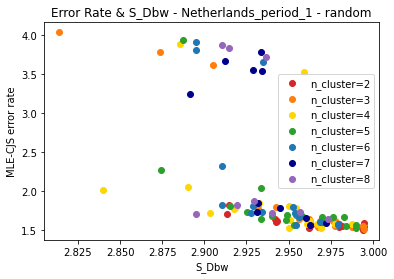

Figure 6.30: Error Rate and S_Dbw of Random Clustering - Netherlands-1


In [78]:
# Figure 6.30: Error Rate and S_Dbw of Random Clustering - Netherlands-1

data_loc_period =  'Netherlands_period_1'
plot_rm_cjs_S_Dbw_err(data_loc_period, nl_rm_s_dbw_record_p1, nl_rm_err_record_p1)

print('Figure 6.30: Error Rate and S_Dbw of Random Clustering - Netherlands-1')

In [79]:
# Table 6.10: Correlation Matrix - Random Clustering in Netherlands-1

nl_rm_random_data_df_p1 = get_rm_df(nl_rm_s_dbw_record_p1, nl_rm_err_record_p1, nl_rm_std_record_p1, nl_rm_time_record_p1)

print('\nTable 6.10: Correlation Matrix - Random Clustering in Netherlands-1')
nl_rm_random_data_df_p1.astype('float64').corr()

err is None: n_cluster=5, label=19
err is None: n_cluster=6, label=5
err is None: n_cluster=6, label=7
err is None: n_cluster=6, label=8
err is None: n_cluster=6, label=11
err is None: n_cluster=6, label=15
err is None: n_cluster=7, label=0
err is None: n_cluster=7, label=3
err is None: n_cluster=7, label=7
err is None: n_cluster=7, label=8
err is None: n_cluster=7, label=10
err is None: n_cluster=7, label=12
err is None: n_cluster=7, label=13
err is None: n_cluster=7, label=16
err is None: n_cluster=7, label=18
err is None: n_cluster=8, label=0
err is None: n_cluster=8, label=1
err is None: n_cluster=8, label=5
err is None: n_cluster=8, label=6
err is None: n_cluster=8, label=8
err is None: n_cluster=8, label=9
err is None: n_cluster=8, label=11
err is None: n_cluster=8, label=15
err is None: n_cluster=8, label=17
err is None: n_cluster=8, label=18
err is None: n_cluster=8, label=19
drop index (err=None): Int64Index([ 79,  85,  87,  88,  91,  95, 100, 103, 107, 108, 110, 112, 113,
   

,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.289229,0.337875,0.339010,0.941581
S_Dbw,-0.289229,1.000000,-0.624004,-0.643119,-0.224072
err,0.337875,-0.624004,1.000000,0.990681,0.192941
std,0.339010,-0.643119,0.990681,1.000000,0.196136
CJS_time,0.941581,-0.224072,0.192941,0.196136,1.000000


In [80]:
nl_ip_date_dict_p0, nl_baseline_ip_sum_p0 = get_baseline_ip_sum(nl_data_period_0)
nl_ip_date_dict_p1, nl_baseline_ip_sum_p1 = get_baseline_ip_sum(nl_data_period_1)
set_baseline_ip_sum['Netherlands'] = [nl_baseline_ip_sum_p0, nl_baseline_ip_sum_p1]
set_ip_date_dict['Netherlands'] = [nl_ip_date_dict_p0, nl_ip_date_dict_p1]

nl_s_dbw_record_p0 = get_s_dbw_record('Netherlands', period_choose=0, label_amount=10)
nl_s_dbw_record_p1 = get_s_dbw_record('Netherlands', period_choose=1, label_amount=10)
set_s_dbw_record['Netherlands'] = [nl_s_dbw_record_p0, nl_s_dbw_record_p1]

nl_ip_trans_count_dict_p0 = get_ip_trans_count_dict(nl_data_period_0)
nl_ip_trans_count_dict_p1 = get_ip_trans_count_dict(nl_data_period_1)
set_ip_trans_count_dict['Netherlands'] = [nl_ip_trans_count_dict_p0, nl_ip_trans_count_dict_p1]

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:50: RuntimeWarning: divide by zero encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p
C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:51: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:50: RuntimeWarning: invalid value encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p


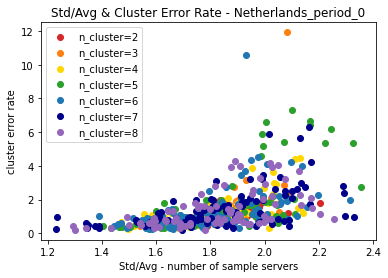

Figure 6.31: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-0


In [81]:
# Figure 6.31: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-0

data_loc = 'Netherlands'
nl_rm_data_cluster_df_p0, nl_rm_data_df_p0 = get_alternative_metric(data_loc, nl_data_period_0, period_choose=0, 
                                                              label_amount=20, err_up_limit=100, random_path=True)
data_loc_period =  'Netherlands_period_0'
plot_StdAvg_ClusterErr(nl_rm_data_cluster_df_p0, data_loc_period)

print('Figure 6.31: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-0')

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:51: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]


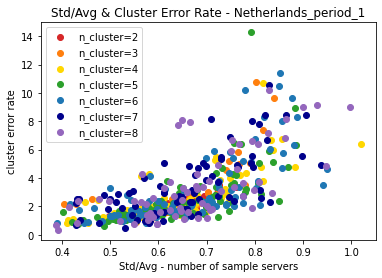

Figure 6.32: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-1


In [82]:
# Figure 6.32: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-1

data_loc = 'Netherlands'
nl_rm_data_cluster_df_p1, nl_rm_data_df_p1 = get_alternative_metric(data_loc, nl_data_period_1, period_choose=1, 
                                                              label_amount=20, err_up_limit=100, random_path=True)
data_loc_period =  'Netherlands_period_1'
plot_StdAvg_ClusterErr(nl_rm_data_cluster_df_p1, data_loc_period)

print('Figure 6.32: Std/Avg and Cluster Error Rate of Random Clustering - Netherlands-1')

In [83]:
# 6.5 CJS Model in Germany

In [84]:
data_loc = 'Germany'
ger_ip_time = read_dataset_csv(data_loc)

data_loc: Germany
num of total server: 1066
time cost: 23.469637155532837
the size of data 124287


In [85]:
# dataset
ger_period_0 = ["2021-06-04", "2021-06-05", "2021-06-06", "2021-06-07", "2021-06-08", "2021-06-09", "2021-06-10", "2021-06-11", "2021-06-12", "2021-06-13", "2021-06-14"]
ger_data_period_0 = get_ip_time(ip_data=ger_ip_time, period=ger_period_0)

ger_data_2021 = get_ip_time(ip_data=ger_ip_time, period='2021')

set_dates['Germany'] = [ger_period_0]

print(f'data_loc: {data_loc}')
for key, value in ger_data_period_0.items():
    print(key)
    print(f'first 5 transaction: {value[0:5]}, \nlast 5 transaction: {value[-5:]}')
    print(f'transaction count: {len(value)}')
    break

data_loc: Germany
185.42.207.23
first 5 transaction: ['2021-06-04T000041', '2021-06-04T000403', '2021-06-04T000414', '2021-06-04T000805', '2021-06-04T000120'], 
last 5 transaction: ['2021-06-10T193827', '2021-06-10T181848', '2021-06-10T184216', '2021-06-10T193559', '2021-06-10T205548']
transaction count: 22721


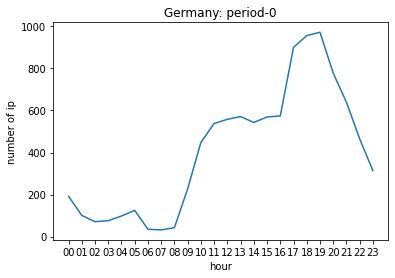

[192, 101, 71, 76, 98, 125, 35, 32, 43, 227, 448, 538, 558, 571, 543, 569, 574, 900, 956, 972, 778, 639, 465, 314]
The Number of IPs in the Germany of each hour


In [86]:
# set sample hour = 19

get_num_ip_hour(ger_data_period_0, 0)

print('The Number of IPs in the Germany of each hour')

In [87]:
# Figure 6.33: The Estimation Result of the CJS model without Clustering - Germany

# the plot is in the folder '../Result/Germany/p2_daily_plot/n_cluster_0.png'


n_cluster: 2
number of error rate > 100: 0
number of nan: 0

n_cluster: 3
number of error rate > 100: 0
number of nan: 0

n_cluster: 4
number of error rate > 100: 0
number of nan: 0

n_cluster: 5
number of error rate > 100: 0
number of nan: 0

n_cluster: 6
number of error rate > 100: 1
number of nan: 0

n_cluster: 7
number of error rate > 100: 2
number of nan: 0

n_cluster: 8
number of error rate > 100: 3
number of nan: 0


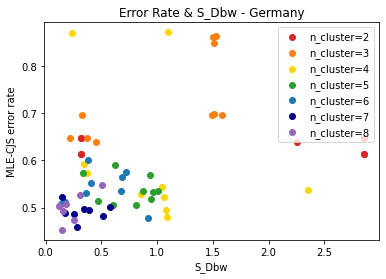

Figure 6.34: The CJS Result of Germany


In [88]:
# Figure 6.34: The CJS Result of Germany

# get records and scatter plot of S_Dbw Score & Error Rate
ger_km_err_record, ger_km_std_record, ger_km_time_record, ger_km_s_dbw_record = plot_cjs_S_Dbw_err(data_loc='Germany', 
                                                                                                   err_up_limit=100)
print('Figure 6.34: The CJS Result of Germany')

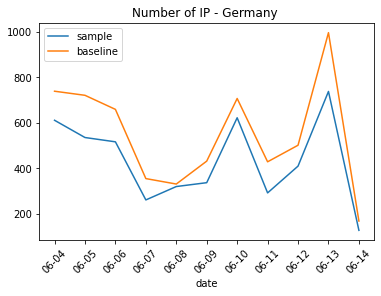

std/avg(sample_num): 177.1096219346035
total number of servers: 1066
std/avg(sample_num): 0.40902914996444223
std/avg(baseline_num): 0.413606148681126
Figure 6.35: The Number of IPs in Each Date - Germany


In [89]:
# Figure 6.35: The Number of IPs in Each Date - Germany

data_loc = 'Germany'
plot_num_ip_date(ger_data_period_0, data_loc)

print('Figure 6.35: The Number of IPs in Each Date - Germany')

In [90]:
ger_ip_date_dict, ger_baseline_ip_sum = get_baseline_ip_sum(ger_data_period_0)
set_baseline_ip_sum['Germany'] = [ger_baseline_ip_sum]
set_ip_date_dict['Germany'] = [ger_ip_date_dict]

ger_s_dbw_record = get_s_dbw_record('Germany', period_choose='', label_amount=10)
set_s_dbw_record['Germany'] = [ger_s_dbw_record]

ger_ip_trans_count_dict = get_ip_trans_count_dict(ger_data_period_0)
set_ip_trans_count_dict['Germany'] = [ger_ip_trans_count_dict]

C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:51: RuntimeWarning: invalid value encountered in divide
  err_class = np.abs( est_num_class[:,1:-2] - baseline_num_class[:,2:-2] ) / baseline_num_class[:,2:-2]
C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:50: RuntimeWarning: divide by zero encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p
C:\Users\smart\AppData\Local\Temp\ipykernel_21716\2940429832.py:50: RuntimeWarning: invalid value encountered in divide
  est_num_class = sum_ch[:, 1:] / est_p


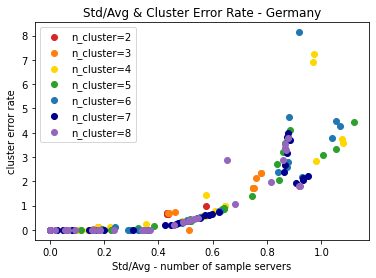

Figure 6.36: Std/Avg and Cluster Error Rate in K-Means - Germany


In [91]:
# Figure 6.36: Std/Avg and Cluster Error Rate in K-Means - Germany

data_loc = 'Germany'
ger_data_cluster_df, ger_data_df = get_alternative_metric(data_loc, ger_data_period_0, period_choose='', 
                                                          label_amount=10, err_up_limit=100)

plot_StdAvg_ClusterErr(ger_data_cluster_df, 'Germany')

print('Figure 6.36: Std/Avg and Cluster Error Rate in K-Means - Germany')

In [92]:
# ch 6.5.3 CJS Model with Random Clustering

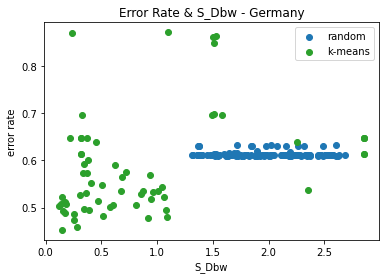

Figure 6.37: K-Means and Random Clustering - Germany


In [93]:
# Figure 6.37: K-Means and Random Clustering - Germany

data_loc = 'Germany'
ger_rm_err_record, ger_rm_std_record, ger_rm_time_record = get_err_std_time_rm(data_loc, period_choose='')

ger_rm_s_dbw_record = get_sdbw_rm(data_loc, period_choose='')
set_rm_s_dbw_record['Germany'] = [ger_rm_s_dbw_record]


data_loc_period =  'Germany'
pyplot.title(f'Error Rate & S_Dbw - {data_loc_period}')
pyplot.xlabel('S_Dbw')
pyplot.ylabel('error rate')

pyplot.scatter(ger_rm_s_dbw_record, ger_rm_err_record, color='tab:blue', label='random')
pyplot.scatter(ger_km_s_dbw_record, ger_km_err_record, color='tab:green', label='k-means')

pyplot.legend()
pyplot.show()

print('Figure 6.37: K-Means and Random Clustering - Germany')

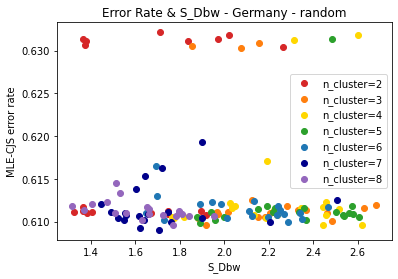

Figure 6.38: Error Rate and S_Dbw of Random Clustering - Germany


In [94]:
# Figure 6.38: Error Rate and S_Dbw of Random Clustering - Germany

data_loc_period =  'Germany'
plot_rm_cjs_S_Dbw_err(data_loc_period, ger_rm_s_dbw_record, ger_rm_err_record)

print('Figure 6.38: Error Rate and S_Dbw of Random Clustering - Germany')

In [95]:
# Table 6.11: Correlation Matrix - Random Clustering in Germany

ger_rm_random_data_df = get_rm_df(ger_rm_s_dbw_record, ger_rm_err_record, ger_rm_std_record, ger_rm_time_record)

print('\nTable 6.11: Correlation Matrix - Random Clustering in Germany')
ger_rm_random_data_df.astype('float64').corr()

mean err: 0.6133009731230494
max CJS time: 56.81287

Table 6.11: Correlation Matrix - Random Clustering in Germany


,n_cluster,S_Dbw,err,std,CJS_time
n_cluster,1.000000,-0.230470,-0.348357,0.061924,0.376957
S_Dbw,-0.230470,1.000000,-0.032409,-0.121525,0.108804
err,-0.348357,-0.032409,1.000000,0.790035,-0.234517
std,0.061924,-0.121525,0.790035,1.000000,-0.025379
CJS_time,0.376957,0.108804,-0.234517,-0.025379,1.000000


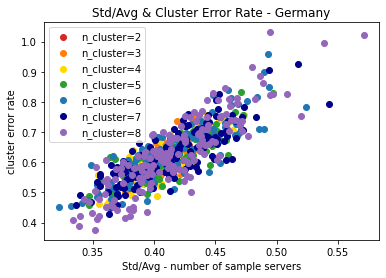

Figure 6.39: Std/Avg and Cluster Error Rate of Random Clustering - Germany


In [96]:
# Figure 6.39: Std/Avg and Cluster Error Rate of Random Clustering - Germany

data_loc = 'Germany'
ger_rm_data_cluster_df, ger_rm_data_df = get_alternative_metric(data_loc, ger_data_period_0, period_choose='', 
                                                              label_amount=20, err_up_limit=100, random_path=True)
data_loc_period =  'Germany'
plot_StdAvg_ClusterErr(ger_rm_data_cluster_df, data_loc_period)

print('Figure 6.39: Std/Avg and Cluster Error Rate of Random Clustering - Germany')